In [2]:
#importing essential libraries
import os
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input,Lambda,Dense,Flatten,Dropout,BatchNormalization,Activation
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,recall_score,precision_score,f1_score
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np

In [3]:
#Creating a function for computing content cost 
def compute_content_cost(content_output, generated_output):
    
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
   
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C]) # Or tf.reshape(a_C, shape=[m, -1 , n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C]) # Or tf.reshape(a_G, shape=[m, -1 , n_C])
    
   
    J_content =  tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))/(4.0 * n_H * n_W * n_C)
    
    return J_content

In [4]:
def gram_matrix(A):
   
    
    GA = tf.matmul(A, tf.transpose(A))
 

    return GA

In [5]:
def compute_layer_style_cost(a_S, a_G):
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
    
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))
    
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    
    J_style_layer = tf.reduce_sum(tf.square(GS - GG))/(4.0 *(( n_H * n_W * n_C)**2))
    
    ### END CODE HERE
    
    return J_style_layer

In [6]:
#Using vgg19 pretrained model
vgg=VGG19(input_shape=(264,264,3),weights='imagenet',include_top=False)
for layer in vgg.layers:
    layer.trainable=False

In [7]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 264, 264, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 264, 264, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 264, 264, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 132, 132, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 132, 132, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 132, 132, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 66, 66, 128)       0     

In [8]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]



In [9]:
#Function to compute style cost for generated image
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    
    J_style = 0

    
    a_S = style_image_output[1:]

    
    a_G = generated_image_output[1:]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        
        J_style += weight[1] * J_style_layer

    return J_style

In [10]:
#Defining Total cost ie content cost + style cost
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    ### START CODE HERE
    
    #(≈1 line)
    J = alpha * J_content + beta * J_style
    
    ### START CODE HERE

    return J

(1, 264, 264, 3)


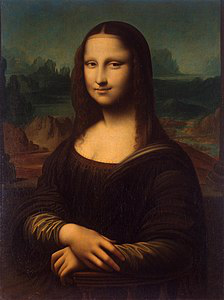

In [12]:
#Importing content image
import numpy as np
from PIL import Image
import PIL.Image as image
c=Image.open("content_image.jpg")
content_image = np.array(c.resize((264,264)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
c


(1, 264, 264, 3)


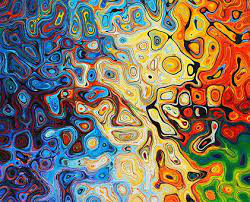

In [13]:
#importing style image
s=Image.open("s1.jpeg")
style_image = np.array(s.resize((264,264)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
s

In [40]:
def generate_noise_image(content_image, noise_ratio = 0.9):
    
    
    
    noise_image = np.random.uniform(-20, 20, (1,264,264,3)).astype('float32')
    
   
    input_image = noise_image * noise_ratio*10 +content_image
    
    return input_image/10

In [41]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), 0, 1)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)

(1, 264, 264, 3)


In [42]:
#check
def generate_noise_image1(content_image, noise_ratio = 0.9):
    
    
    
    noise_image = np.random.uniform(-20, 20, (1,264,264,3)).astype('float32')
    
   
    input_image = noise_image * noise_ratio*0 +content_image*0
    
    return input_image/10

generated_image= generate_noise_image1(content_image,0.9)

In [43]:
def get_layer_outputs(vgg, layer_names):
    
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [44]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [45]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style enconder

In [46]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input.
a_G = vgg_model_outputs(generated_image)

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

print(J_content)

tf.Tensor(0.008588523, shape=(), dtype=float32)


In [47]:
# Assigning the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

# Computing the style cost
J_style = compute_style_cost(a_S, a_G)
print(J_style)

tf.Tensor(2092.9656, shape=(), dtype=float32)


In [48]:
def modify(image):
    
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [49]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.09)


def train_step(generated_image, alpha = 40, beta = 20):
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C
        # Compute a_G as the vgg_model_outputs for the current generated image
        
        ### START CODE HERE
        
        #(1 line)
        a_G = vgg_model_outputs(generated_image)
        
        # Compute the style cost
        #(1 line)
        J_style = compute_style_cost(a_S, a_G)

        #(2 lines)
        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)
        # Compute the total cost
        J = total_cost(J_content, J_style,alpha = alpha, beta = beta)
        
        ### END CODE HERE
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(modify(generated_image))
    # For grading purposes
    return J

In [50]:
from tensorflow.python.framework.ops import EagerTensor
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

J1 = train_step(generated_image)
print(J1)
assert type(J1) == EagerTensor, f"Wrong type {type(J1)} != {EagerTensor}"

J2 = train_step(generated_image)
print(J2)

tf.Tensor(34689.516, shape=(), dtype=float32)
tf.Tensor(21322.996, shape=(), dtype=float32)


Epoch 0 


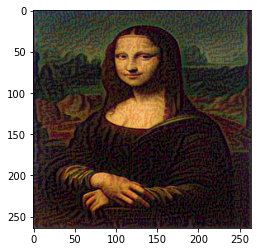

Epoch 10 


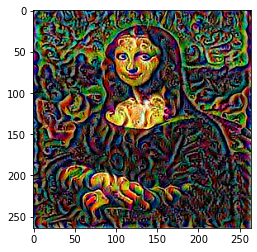

Epoch 20 


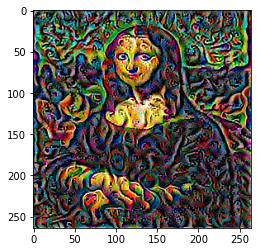

Epoch 30 


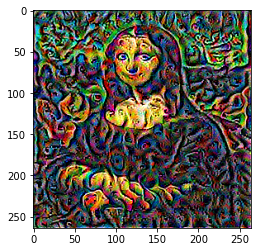

Epoch 40 


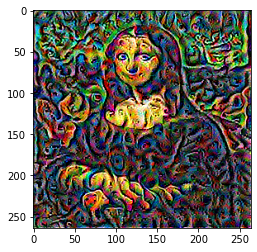

Epoch 50 


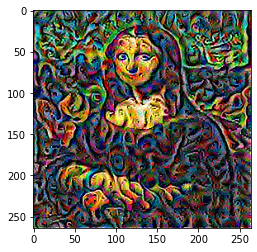

Epoch 60 


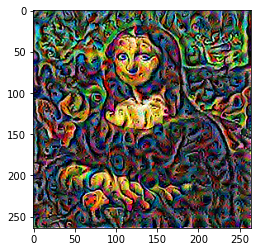

Epoch 70 


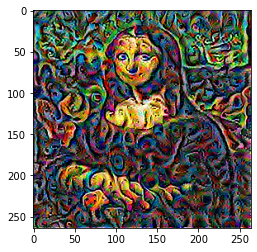

Epoch 80 


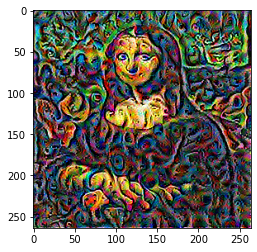

Epoch 90 


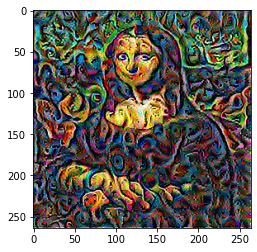

In [51]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

epochs = 100
for i in range(epochs):
    train_step(generated_image)
    if i % 10 == 0:
        print(f"Epoch {i} ")
    if i % 10 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        
        plt.show() 
